In [1]:
import pandas as pd
import numpy as np

### import data

In [2]:
df = pd.read_csv('../csvs/features.csv',index_col=0)
df_regional = pd.read_csv('../csvs/regional_features.csv',index_col=0)
df.dropna(inplace=True)
df_regional.dropna(inplace=True)
df_regional.drop(['file','label'],axis=1,inplace=True)

In [3]:
df = pd.concat([df, df_regional], axis=1)

In [4]:
X = df.drop(['file','label'],axis=1).values
y = df.label.values
y_bin = (y!=0).astype(int)
print('X (data)',X.shape,type(X))
print('y (target)',y.shape,type(y),np.unique(y))
print('y_bin (binary target)',y_bin.shape,type(y_bin),np.unique(y_bin))

X (data) (1005, 119) <class 'numpy.ndarray'>
y (target) (1005,) <class 'numpy.ndarray'> [ 0.  1.  2.  3.]
y_bin (binary target) (1005,) <class 'numpy.ndarray'> [0 1]


### preprocess data to have mean=0 and variance=1

In [5]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)

### testing models

In [6]:
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

In [7]:
clfs = []
clfs.append([svm.SVC(),'default svm'])
clfs.append([svm.SVC(kernel='linear'),'svc kernel linear'])
clfs.append([LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),'logistic reg'])
clfs.append([AdaBoostClassifier(n_estimators=100), 'adaboost'])
clfs.append([KNeighborsClassifier(n_neighbors=3), 'knn 3'])
clfs.append([MLPClassifier(solver='lbfgs', alpha=1e-5,
                           hidden_layer_sizes=(5, 2), random_state=1),'NN'])
estimators = []
for clf, clf_str in clfs:
    estimators.append((clf_str, clf))
eclf = VotingClassifier(estimators=estimators, voting='hard')

### pca

In [13]:
pca_scores = []
from sklearn.decomposition import PCA
for i in range(1, X_scaled.shape[1] + 1):
    pca = PCA(n_components = i)
    pca.fit(X_scaled)
    X_pca = pca.transform(X_scaled)
    scores = cross_val_score(eclf, X_pca ,y_bin, cv=5)
    pca_scores.append(scores.mean())

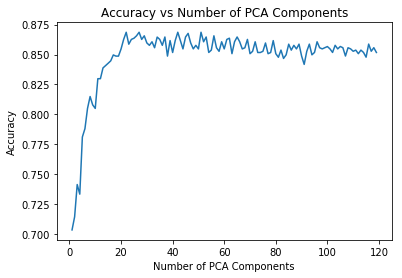

In [22]:
import matplotlib.pyplot as plt
plt.plot([x for x in range(1, len(pca_scores) + 1)], pca_scores)
plt.title('Accuracy vs Number of PCA Components')
plt.ylabel('Accuracy')
plt.xlabel('Number of PCA Components')
plt.show()

In [19]:
df = pd.DataFrame(pca_scores)
df.to_csv('pca_scores.csv', index=False, header=False)